## Lab 5: Supervised classification

**Purpose:**
The purpose of this lab is introduce you to concepts of supervised classification and regression: prediction of nominal or numeric values of a geographic variable from other geographic variables.  You will explore processes of training data collection, classifier selection, classifier training, image classification and accuracy assessment.  At the completion of the lab, you will be able to perform supervised classification and regression in Earth Engine.

**Prerequisites:** Lab 4

### 1. Introduction to classification and regression
For present purposes, define prediction as guessing the value of some geographic variable of interest *g*, using a function *G* that takes as input a pixel vector **p**:

\begin{equation}
G_{T}(p_i) = g_i 
\end{equation}

The *i* in this equation refers to a particular instance from a set of pixels.  Think of *G* as a guessing function and *gi* as the guess for pixel *i*.   The **T** in the subscript of *G* refers to a *training set* (a set of known values for p and the correct g), used to infer the structure of G.  You have to choose a suitable *G* to train with **T**.  When *g* is nominal (e.g. {'water', 'vegetation', 'bare'}), call this setup classification.  When g is numeric, call this setup regression.  This is an incredibly simplistic description of a problem addressed in a broad range of fields including mathematics, statistics, data mining, machine learning, etc.  Interested readers may see [Witten et al. (2011)](http://www.cs.waikato.ac.nz/ml/weka/book.html), [Hastie et al. (2009)](http://statweb.stanford.edu/~tibs/ElemStatLearn/) or [Goodfellow et al (2016)](http://www.deeplearningbook.org/).

### Classification
Classification in Earth Engine has a similar workflow to regression: build the training, train the classifier, classify an image.


In classification, g is nominal.  The first step is to create training data manually.  (Alternatively, upload a shapefile  training data, for example data collected on the ground with a GPS).  Using the geometry tools and the Landsat composite as a background, digitize training polygons.

In [1]:
# Initializing display and earthengine
from IPython.display import Image
%matplotlib inline

import ee
ee.Initialize()

# importing ipygee for dynamic mapping
from ipygee import *

Map = Map() # from ipygee
Map.show()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

- Import data to use as predictor variables (**p**).  Search 'landsat 5 raw' and import 'USGS Landsat 5 TM Collection 1 Tier 1 Raw Scenes'.  Name the import l5raw.  Filter by time and the [WRS-2](http://landsat.usgs.gov/worldwide_reference_system_WRS.php) path and row to get only scenes over the San Francisco bay area in 2010:


In [2]:
l5raw = ee.ImageCollection("LANDSAT/LT05/C01/T1")

l5filtered = l5raw.filterDate('2010-05-01', '2010-10-31').\
filterMetadata('WRS_PATH', 'equals', 44).\
filterMetadata('WRS_ROW', 'equals', 34)

Use an Earth Engine algorithm to get a cloud-free composite of Landsat imagery in 2010. Also apply the *waterMask* mask to the *landsat* composite.

In [3]:
landsat = ee.Algorithms.Landsat.simpleComposite(l5filtered,50,10,40, True)

# landsat = landsat.updateMask(waterMask)
# print(landsat.getInfo())
Map.addLayer(landsat, {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}, 'False color composite')

Map.centerObject(l5filtered.first().geometry()) #centering the map to landsat scene

Define areas that have unique characteristics: bare soil, water, vegetation

In [4]:
# FOR BARE SOIL

# // Create an ee.Geometry.
polygon = ee.Geometry.Polygon([
  [-121.39030016076934, 37.60807367330306],
                  [-121.37889487541446, 37.61763764877222],
                  [-121.38989113432118, 37.62488608266359],
                  [-121.4012069200709, 37.615507786825766]]);

# // Create a Feature from the Geometry.
baresoil = ee.Feature(polygon, {'class': 2, 'name': 'bare soil'});
Map.addLayer(baresoil, {'fill_color':'yellow', 'outline': 1}, name='baresoil')

In [5]:
# FOR WATER

# // Create an ee.Geometry.
polygon = ee.Geometry.Polygon([
  [-122.27695595509044, 37.6833127863229],
                  [-122.26635383955467, 37.683182346233664],
                  [-122.26478644790062, 37.70212710506073],
                  [-122.27107078047028, 37.70228065145053],
                  [-122.27474738958558, 37.701963093009745]]);

# // Create a Feature from the Geometry.
water = ee.Feature(polygon, {'class': 0, 'name': 'water'});
Map.addLayer(water, {'fill_color':'blue', 'outline': 1}, name='water')

In [6]:
# FOR VEGETATION

# // Create an ee.Geometry.
polygon = ee.Geometry.Polygon([
   [-122.24448548567862, 37.21542815360734],
                  [-122.240411435295, 37.21551898615349],
                  [-122.23457428064451, 37.21555749104616],
                  [-122.23385777982398, 37.23144541800057],
                  [-122.24444605659103, 37.23132764751063]]);

# // Create a Feature from the Geometry.
vegetation = ee.Feature(polygon, {'class': 1, 'name': 'vegetation'});
Map.addLayer(vegetation, {'fill_color':'green', 'outline': 1}, name='vegetation')

Merge Features into a Feature Collection

In [7]:
trainingFeatures = ee.FeatureCollection([water, vegetation, baresoil])


Specify the bands of the Landsat composite to be used as predictors (i.e. the elements of p):


In [8]:
predictionBands = ['B1', 'B2', 'B3', 'B4', 'B5' ,'B7']

In the merged FeatureCollection, each Feature should have a property called 'class' where the classes are consecutive integers, one for each class, starting at 0.  Verify that this is true.  Create a training set T for the classifier by sampling the Landsat composite with the merged features:

In [9]:
classifierTraining = landsat.select(predictionBands).sampleRegions(
      collection= trainingFeatures, 
      properties= ['class'], 
      scale= 30
    );

In [10]:
# // Randomly split the data into 60% for training, and 40% for testing
trainingTesting = classifierTraining.randomColumn('random',111009);

training = trainingTesting.filter(ee.Filter.lt('random', 0.6));

testing = trainingTesting.filter(ee.Filter.gte('random', 0.6));

### - Non-linear regression functions

If the garden variety linear regression isn't satisfactory, Earth Engine contains other functions that can make predictions of a continuous variable.  Unlike linear regression, other regression functions are implemented by the classifier library.  

- For example, a Classification and Regression Tree (CART, see Brieman et al. 1984) is a machine learning algorithm that can learn non-linear patterns in your data.  Reusing the T table (without the constant term), train a CART as follows:

In [11]:
cartclassifier = ee.Classifier.cart(randomSeed=111009).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    );

- Make predictions over the input imagery (classify in this context is a misnomer):


In [12]:
cartClasifficationImage = landsat.select(predictionBands).classify(cartclassifier);

Map.addLayer(cartClasifficationImage, {'min': 0, 'max': 2,
                                   'palette':['blue', 'green','yellow']},'CART classification');

example https://code.earthengine.google.com/ade42831c23ae03ab9b26289d89b31f2

Use a Random Forest classifier

In [13]:
rfClassification = ee.Classifier.smileRandomForest(numberOfTrees=1, seed=111009).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )

In [14]:
# // Perform the RF regression on the landsat image
rfClassificationImage = landsat.select(predictionBands).classify(rfClassification);
    
# // Visualize the RF regression
Map.addLayer(rfClassificationImage,  {'min': 0, 'max': 2,
                                   'palette':['blue','green', 'yellow']}, 'RF classification');

Using Support Vector Machines

In [15]:
# ee.Classifier.libsvm(decisionProcedure, svmType, kernelType, shrinking, degree, gamma, coef0, cost, nu, terminationEpsilon, lossEpsilon, oneClass)

# // Create an SVM classifier with custom parameters.
svClassification = ee.Classifier.libsvm(kernelType='RBF',gamma=1,cost=100).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )

In [16]:
# // Perform the RF regression on the landsat image
svClassificationImage = landsat.select(predictionBands).classify(svClassification);
    
# // Visualize the RF regression
Map.addLayer(svClassificationImage,{'min': 0, 'max': 2,
                                   'palette':['blue', 'green','yellow']}, 'SV CLassification');

In the classification context, accuracy measurements are often derived from a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

### Accuracy Assessment

d.	Print the confusion matrix and expand the object to inspect the matrix.  The entries represent number of pixels.  Items on the diagonal represent correct classification.  Items off the diagonal are misclassifications, where the class in row i is classified as column j.  It's also possible to get basic descriptive statistics from the confusion matrix.  For example:

In [17]:
# // Perform the CART classification on the test set

test=testing.classify(cartclassifier)
# print(test.first().getInfo())
# // Get a confusion matrix representing expected accuracy.
testAccuracy = test.errorMatrix('class', 'classification');

In [18]:
import numpy as np
errormaxtrix=np.array(testAccuracy.array().getInfo())

print(testAccuracy.name());
print(errormaxtrix)
print('Overall Accuracy:', testAccuracy.accuracy().getInfo());
print('Producers Accuracy:', testAccuracy.producersAccuracy().getInfo());
print('Consumers Accuracy:', testAccuracy.consumersAccuracy().getInfo());
print('Kappa:', testAccuracy.kappa().getInfo());


ConfusionMatrix
[[1035    0    0]
 [   0  856    0]
 [   0    0 1007]]
Overall Accuracy: 1
Producers Accuracy: [[1], [1], [1]]
Consumers Accuracy: [[1, 1, 1]]
Kappa: 1


In [19]:
# // Perform the RF regression on the test set

test=testing.classify(rfClassification)
# print(test.first().getInfo())
# // Get a confusion matrix representing expected accuracy.
testAccuracy = test.errorMatrix('class', 'classification');

errormaxtrix=np.array(testAccuracy.array().getInfo())

print(testAccuracy.name());
print(errormaxtrix)
print('Overall Accuracy:', testAccuracy.accuracy().getInfo());
print('Producers Accuracy:', testAccuracy.producersAccuracy().getInfo());
print('Consumers Accuracy:', testAccuracy.consumersAccuracy().getInfo());
print('Kappa:', testAccuracy.kappa().getInfo());


ConfusionMatrix
[[1035    0    0]
 [   0  856    0]
 [   0    0 1007]]
Overall Accuracy: 1
Producers Accuracy: [[1], [1], [1]]
Consumers Accuracy: [[1, 1, 1]]
Kappa: 1


In [20]:
# // Perform the SVR regression on the test set

test=testing.classify(svClassification)
# print(test.first().getInfo())
# // Get a confusion matrix representing expected accuracy.
testAccuracy = test.errorMatrix('class', 'classification');

errormaxtrix=np.array(testAccuracy.array().getInfo())

print(testAccuracy.name());
print(errormaxtrix)
print('Overall Accuracy:', testAccuracy.accuracy().getInfo());
print('Producers Accuracy:', testAccuracy.producersAccuracy().getInfo());
print('Consumers Accuracy:', testAccuracy.consumersAccuracy().getInfo());
print('Kappa:', testAccuracy.kappa().getInfo());


ConfusionMatrix
[[1035    0    0]
 [   0  856    0]
 [   0    0 1007]]
Overall Accuracy: 1
Producers Accuracy: [[1], [1], [1]]
Consumers Accuracy: [[1, 1, 1]]
Kappa: 1


### BONUS: Hyperparameters tuning

A random forest is a collection of random trees the predictions of which are used to compute an average (regression) or vote on a label (classification).  Note that the only parameter to the classifier is the number of trees (10).  How many trees should you use?  Making that choice is best done by hyperparameter tuning.  For example, 


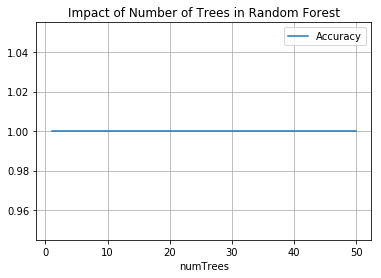

In [21]:
numTrees = ee.List.sequence(1, 50, 1)


def trees(t):
    rfclass = ee.Classifier.smileRandomForest(numberOfTrees=t, seed=111009).train(
    features= training, 
    classProperty= 'class', 
    inputProperties= predictionBands)
    
    rfTesting = testing.classify(rfclass)
    testAccuracy = rfTesting.errorMatrix('class', 'classification');
    accuracy= testAccuracy.accuracy();       
    return accuracy


accuracy_trees=numTrees.map(trees)
value_info = accuracy_trees.getInfo()

# print(rmse_trees.getInfo())

import pandas as pd
df =pd.DataFrame(value_info,columns=['Accuracy'])
df['numTrees'] = numTrees.getInfo() 

ax =df.plot.line(x='numTrees', 
             y='Accuracy',
             title= 'Impact of Number of Trees in Random Forest'
             )
ax.grid()

same for svr

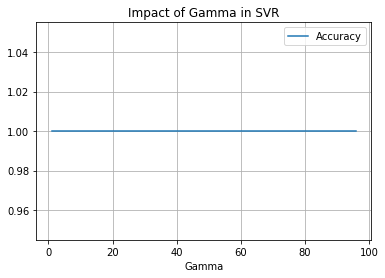

In [22]:
gamma_vals = ee.List.sequence(1, 100, 5)


def gammas(t):
    svclass = ee.Classifier.libsvm(kernelType='RBF',gamma=t,cost=1).train(
      features= training, 
      classProperty= 'class', 
      inputProperties= predictionBands
    )
    
    svTesting = testing.classify(svclass)
    testAccuracy = svTesting.errorMatrix('class', 'classification');
    accuracy= testAccuracy.accuracy();       
    return accuracy


accuracy_gama=gamma_vals.map(gammas)
value_info = accuracy_gama.getInfo()

# print(rmse_gama.getInfo())

import pandas as pd
df =pd.DataFrame(value_info,columns=['Accuracy'])
df['Gamma'] = gamma_vals.getInfo() 

ax =df.plot.line(x='Gamma', 
             y='Accuracy',
             title= 'Impact of Gamma in SV'
             )
ax.grid()

### Assignment

Recreate this notebook for Florida, a humid climate with a variety of forest (natural to agriculture). Make sure your SVR and Random Forest uses the tuned hyperparameters when discussing your RMSE found. Are the 4 models behaving similarly? Do they statistically perform different than this example? Discuss it.